# SI 370 - Homework #5: Classifiers
or: How I Learned to Stop Worrying and Love Machine Learning

Version 2024.11.05.2.CT

This is, perhaps, one of the most exciting homework assignments that you have
encountered in this course!

Similar to what we introduced you to last class, you are going to try your hand at a Kaggle competition to predict which passengers onboard the Spaceship Titanic will be transported to an alternate dimension.

(NOTE: if you prefer to not submit your work to the Kaggle competition that's fine --
just contact Chris via email (cteplovs@umich.edu) and we will work out an alternative.)

To start navigate to the [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic) project page.

The basic steps for this assignment were outlined in the video from last class:

1. Accept the rules and join the competition
2. Download the data (from the data tab of the competition page)
3. Understand the problem
4. EDA (Exploratory Data Analysis)
5. Train, tune, and ensemble (!) your machine learning models
6. Upload your prediction as a submission on Kaggle and receive an accuracy score

additionally, you will

7. Upload your final notebook to Canvas and report your best accuracy score.  

Note that class grades are not entirely dependent on your accuracy score.  
All models that achieve 80% accuracy will receive full points for 
the accuracy component of this assignment.

Some additional notes:

1. If you use another notebook, code, or approaches be sure to reference the original work. (Note that we recommend you study existing Kaggle notebooks before starting your own work.)
2. If you use ChatGPT, or any other generative AI helper, be sure to reference that as well.
3. You can help each other but in the end you must submit your own work, both to Kaggle and to Canvas.

Some additional resources:

* "ensemble" your models with a [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
* a good primer on [feature engineering](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)
* There are a lot of good [notebooks to study](https://www.kaggle.com/competitions/spaceship-titanic/code) (check the number of upvotes to help guide your exploration)

## GOOD LUCK!
(and don't cheat... cheating on this assignment will result in a grade of zero.  Please note that undocumented use of generative AI is considered cheating.)

One final note:  Your submission should be a self-contained notebook that is NOT based
on this one.  Studying the existing Kaggle competition notebooks should 
give you a sense of what makes a "good" notebook.

## Importing Libraries

In [1]:
#importing the 'usual' suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importing ml models
from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_graphviz
# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [3]:
#importing extra ml tools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier


## Reading in & Exploring the Data

In [4]:
#set up directory to the data
directory = "../data/spaceship-titanic"

#load in training and test data
train_data = pd.read_csv(f"{directory}/train.csv")

test_data = pd.read_csv(f"{directory}/test.csv")

### Exploring the training data

In [5]:
#display first five rows
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
#convert bool rows to 0 and 1
#did not convert transported as this is the label

train_data["VIP"] = train_data["VIP"].astype(float) #convert the bool to 0 and 1
train_data["CryoSleep"] = train_data["CryoSleep"].astype(float) #convert the bool to 0 and 1

In [7]:
#ensure the change worked
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [8]:
#check the distribution of numeric values
train_data.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8476.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,0.358306,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791
std,0.479531,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [9]:
#check the type of each row col and null value count
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   float64
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   float64
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(8), object(5)
memory usage: 891.5+ KB


### Exploring the test data

In [10]:
#display first five rows
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [11]:
#update the bool cols to be 0 & 1 as before

test_data["VIP"] = test_data["VIP"].astype(float) #convert the bool to 0 and 1
test_data["CryoSleep"] = test_data["CryoSleep"].astype(float) #convert the bool to 0 and 1

In [12]:
#check the change worked
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,1.0,G/3/S,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,0.0,F/4/S,TRAPPIST-1e,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,1.0,C/0/S,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,0.0,C/1/S,TRAPPIST-1e,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,0.0,F/5/S,TRAPPIST-1e,20.0,0.0,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [13]:
#check the type of each row col and null value count
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   float64
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   float64
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(8), object(5)
memory usage: 434.5+ KB


### Basic EDA

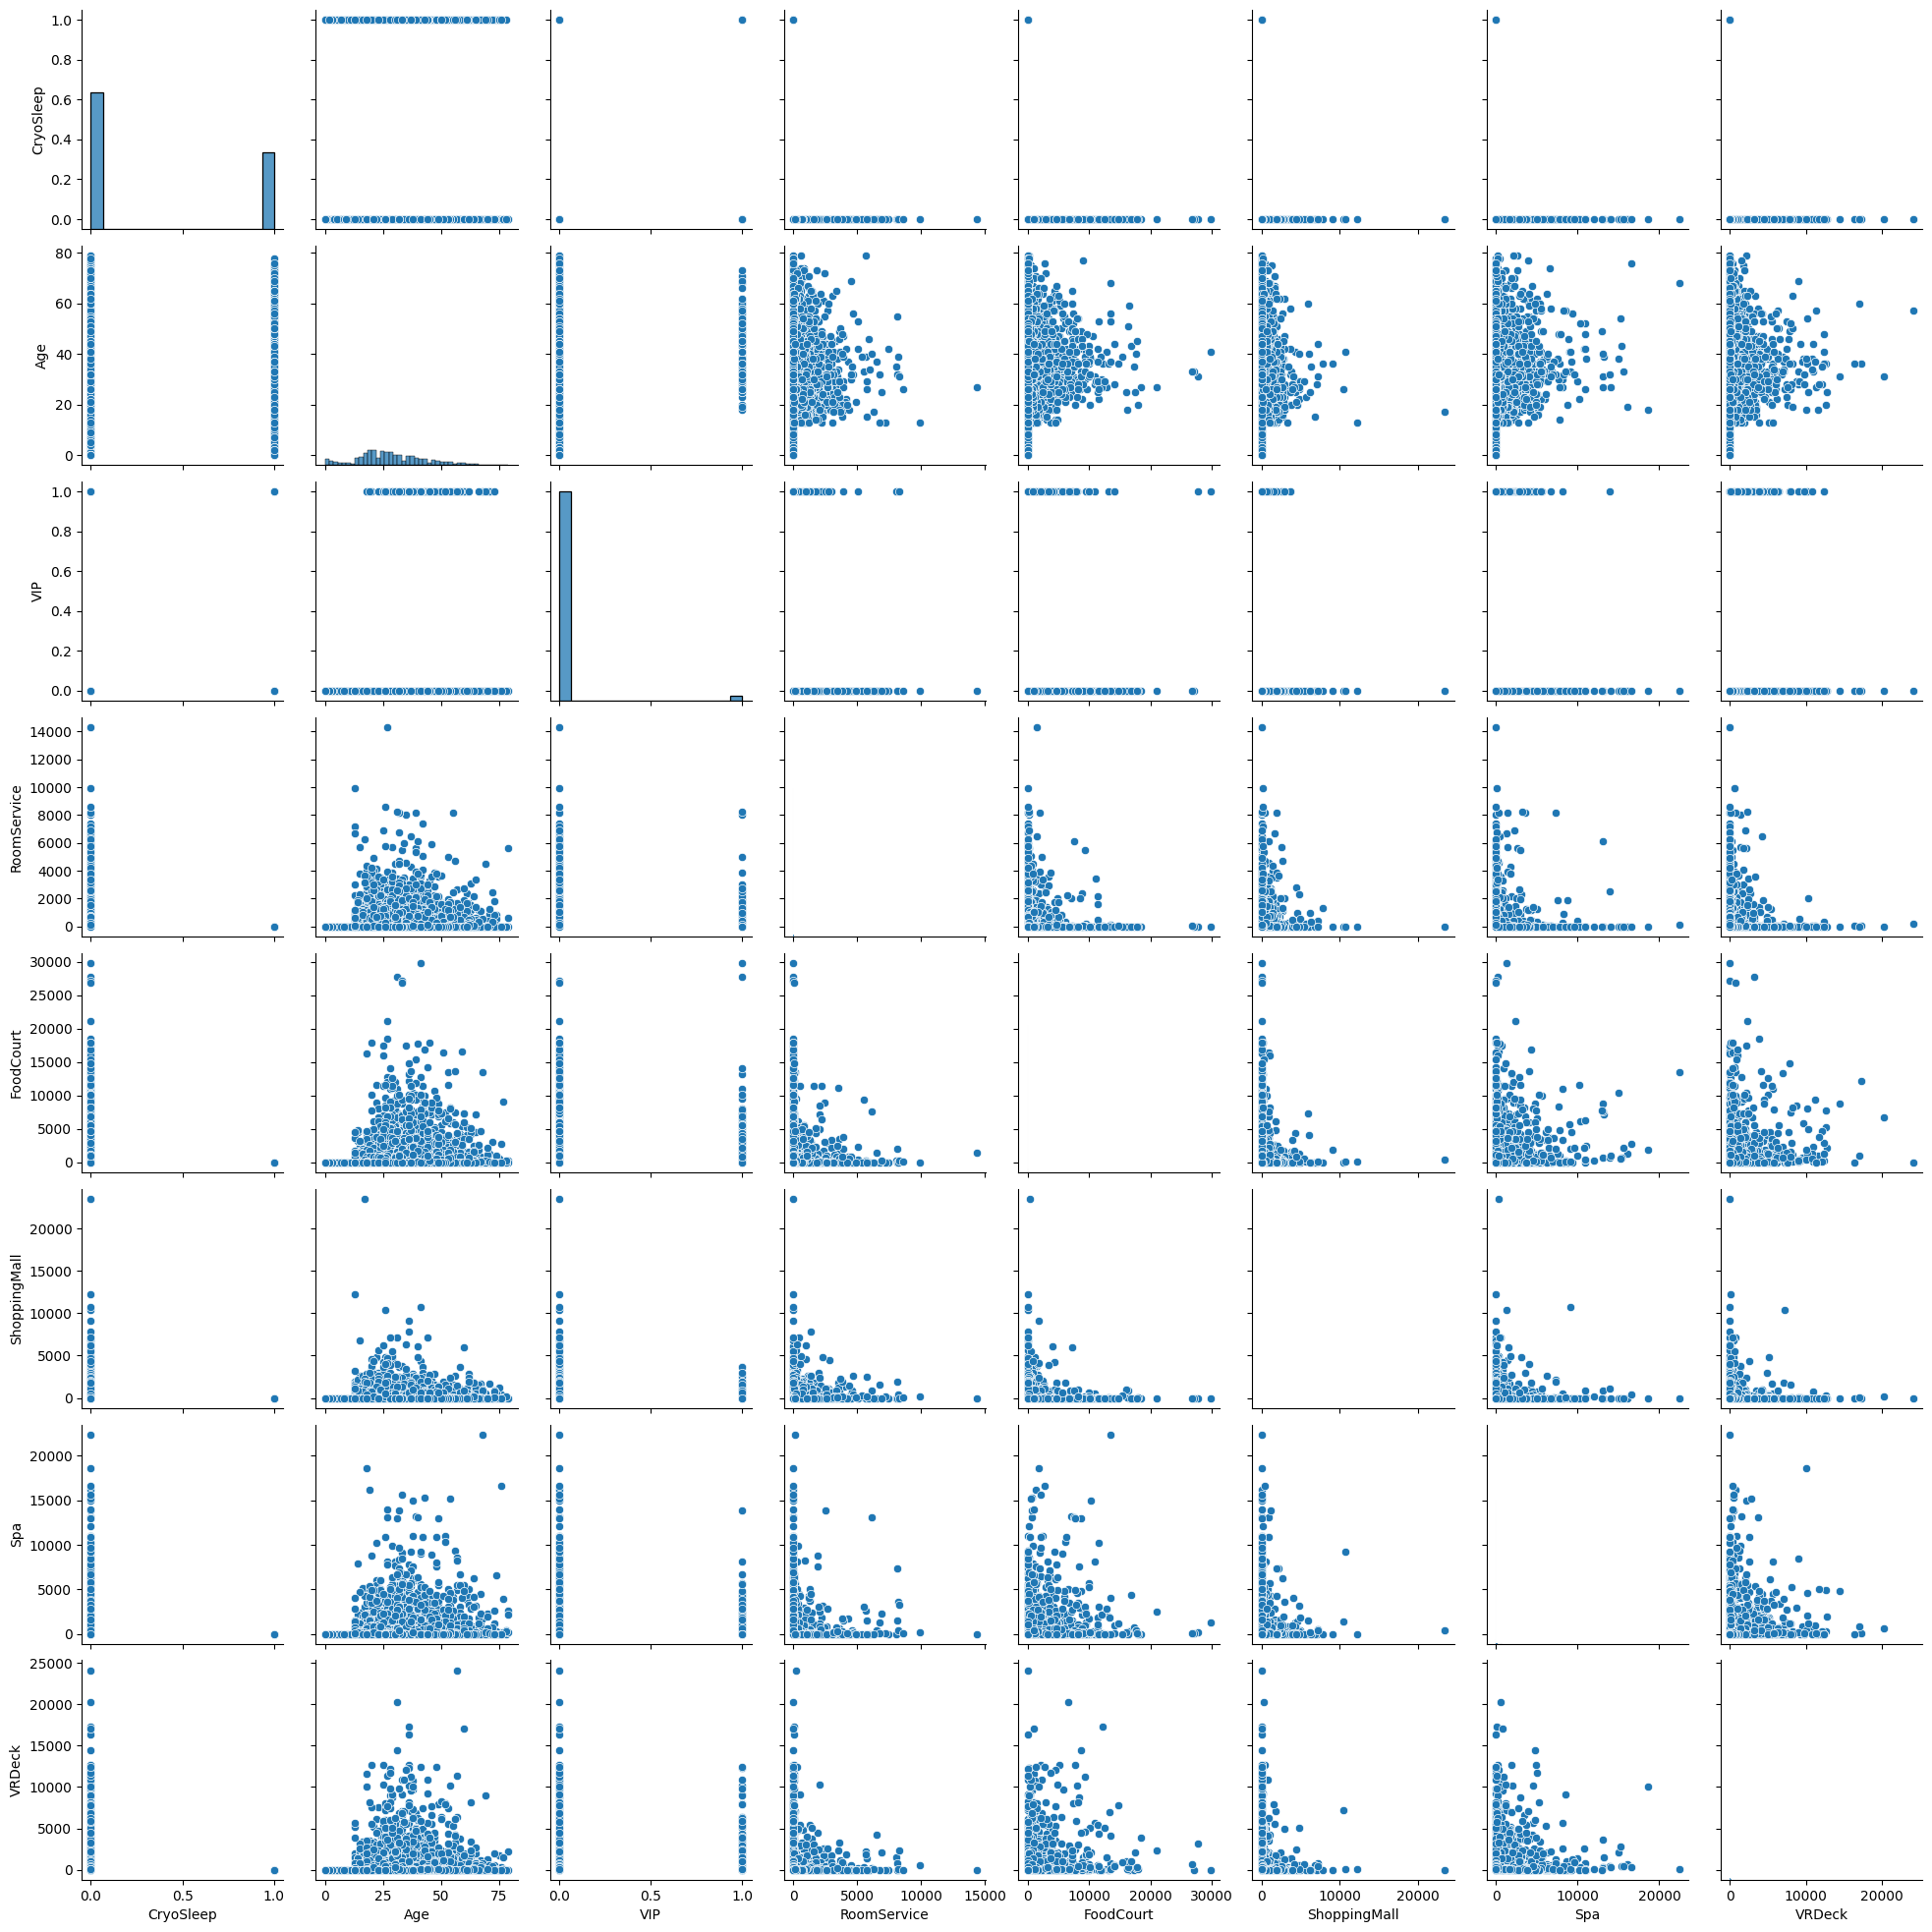

In [14]:
#create a pairplot of only numeric values to see potential relationships and distributions
sns.pairplot(data=train_data.select_dtypes(include=["number"]))

In [15]:
#looking through the home planet values
train_data["HomePlanet"].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

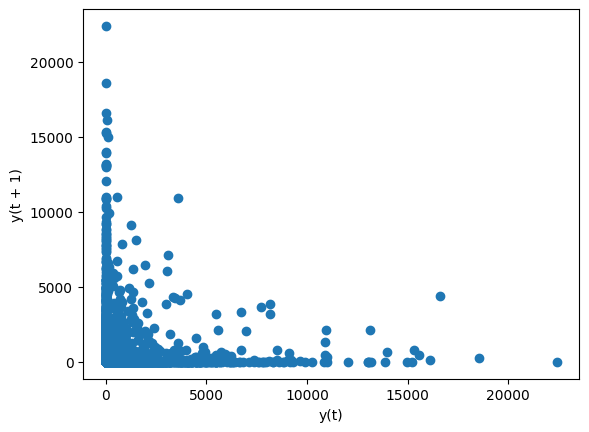

In [16]:
# trying a lag plot (did not yield useful information for any column)
pd.plotting.lag_plot(train_data["Spa"])

**Description:**  The main take aways from my EDA are the following:

1. It is better for bool columns to be made numeric (0 and 1) than left as True/False since we need to use numeric values for basically any machien learning.  Because of this fact, I converted all of the bool columns to be numbers
2. There are null values in the data, meaning I need to address this when processing the data or just drop them all together.  I feel like dropping them is the easy option, but not necessarily better.  So, I am electing to handle them in the pipeline step instead (see later in the notebook)
3. Many of the columns relating to the purchasing habits of users have larger outliers and a majority of data points at lower values.  I don't want to drop these outlier, but it suggests that using a median is a better measure of center here than a mean.
4. Lagplots had not real trends in them (see spa above) for the numeric values, so this indicates that the data is random.
5. From all of this, I decided to use HomePlane, CryoSleep, Cabin, Destination, Age, VIP, RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck as potential classifiers as each should tell us something about the person that can be compared against others.

## Prepocessing for Machine Learning

### Setting up the Functions

In [17]:
#define a function to create numerical and categorical pipelines
#returns the transformed data after running it through the pipelines
def make_num_cat_pipelines(num_attribs, cat_attribs, data):

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

    cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="constant", fill_value="N/A")),
    ("cat", OrdinalEncoder()),
    ])

    new_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

    return new_pipeline.fit_transform(data)

In [18]:
#setting up a test for the function
num_attribs = train_data.select_dtypes(include=["number"]).columns
cat_attribs = train_data.drop(["PassengerId", "Name"],axis=1).select_dtypes(include=["object"]).columns
class_data = train_data.drop(["PassengerId", "Transported", "Name"],axis=1)

In [19]:
#running the function on the test values
example_array = make_num_cat_pipelines(num_attribs, cat_attribs, class_data)

In [20]:
#define a functiont to create a dataframe from the transformed data
def create_tr_data(array, num_attribs, cat_attribs, label_data=None):
    array_df = pd.DataFrame(array, columns=num_attribs.tolist() + cat_attribs.tolist())
    if type(label_data) != type(None):
        return pd.concat([array_df, label_data],axis=1)
    else:
        return array_df

#run the function on the example values
example_df_tr = create_tr_data(example_array, num_attribs, cat_attribs, train_data["Transported"])

In [21]:
#define a function to create X and y values from a dataframe
def create_X_y(data, label):
    return data.drop(label, axis=1), data[label].copy()


#testing the function on the example values
example_X, example_y = create_X_y(example_df_tr, "Transported")


In [22]:
#define a functiont to run a model on the data
def run_model(tup, X_train, y_train, X_test, y_test=None):
    #print the model name
    print(tup[0]) 

    #pull out the model
    model = tup[1]

    #fit the model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #print the accuracy if y_test is provided
    if y_test:
        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))

        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

    #plot the feature importance if the model is Random Forest
    if tup[0] == "Random Forest":
        feat_importance = model.feature_importances_
        pd.DataFrame({'Feature Importance':feat_importance},
                     index=list(X_train)).plot(kind='barh')

    #return the predictions
    return y_pred


### Trying a basic model on the data

In [23]:
#set up models dict to test the function
models = {"Naive_Bayes": GaussianNB(), 
          "SVC": svm.SVC(gamma ='auto', probability = True), 
          "Decision_Tree" : DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=3), 
          "Logistic_Regression": LogisticRegression(max_iter=1000),
          "Random_Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1)}



#create dictionary to store predictions
model_preds = {}

#set up test data and X values
test_class_data = test_data[num_attribs.tolist() + cat_attribs.tolist()]

test_X = create_tr_data(make_num_cat_pipelines(num_attribs, cat_attribs, test_class_data), \
                            num_attribs, cat_attribs)

# test_X

#run the function on each model and save it to a dictionary
for tup in models.items():
    model_preds[tup[0]] = run_model(tup, example_X, example_y, test_X)

Naive_Bayes
SVC
Decision_Tree
Logistic_Regression
Random_Forest


In [24]:
#looking at random forest's predictions
model_preds["Random_Forest"]

array([ True, False,  True, ...,  True,  True, False])

In [25]:
#save random forest as first guess to see how accurate it is
first_guess = pd.DataFrame(model_preds["Random_Forest"],index=test_data["PassengerId"],columns=["Transported"])
first_guess.to_csv("random_forest_1.csv")

**Results of First Guess**:  This first guess got an accurary of .69.  This is not great and defintely need works, but I have not tuned any parameters nor compared methods to see which model is the most accurate, so it is a good start!

## Improving the Model

In [26]:
#define a function that compares the model accuracy against each other model
def compare_models(model_preds):

    #set up dictionary to store the comparisons
    model_comps = {}

    #loop through each model
    for current_model in model_preds:
        d = {}
        #loop through each model again
        for model in model_preds: 

            #skip if the model is the same as the current model
            if model == current_model:
                continue

            #store the accuracy of the model against the current model
            d[model] = round(accuracy_score(model_preds[current_model], model_preds[model])*100,2)

        #store the average accuracy of the model against all other models
        d["Average"] = round(sum(d.values())/len(d.values()),2)

        #adds d to the overall comparison dictionary
        model_comps[current_model] = d

    return model_comps

#running the function with the basic model_preds
model_comps = compare_models(model_preds)

In [27]:
#displaying the model comparisons
model_comps

{'Naive_Bayes': {'SVC': 54.78,
  'Decision_Tree': 62.87,
  'Logistic_Regression': 83.28,
  'Random_Forest': 71.92,
  'Average': 68.21},
 'SVC': {'Naive_Bayes': 54.78,
  'Decision_Tree': 62.4,
  'Logistic_Regression': 60.65,
  'Random_Forest': 63.69,
  'Average': 60.38},
 'Decision_Tree': {'Naive_Bayes': 62.87,
  'SVC': 62.4,
  'Logistic_Regression': 77.76,
  'Random_Forest': 74.58,
  'Average': 69.4},
 'Logistic_Regression': {'Naive_Bayes': 83.28,
  'SVC': 60.65,
  'Decision_Tree': 77.76,
  'Random_Forest': 83.26,
  'Average': 76.24},
 'Random_Forest': {'Naive_Bayes': 71.92,
  'SVC': 63.69,
  'Decision_Tree': 74.58,
  'Logistic_Regression': 83.26,
  'Average': 73.36}}

In [28]:
#save logistic regression as first guess to see how accurate it is
second_guess = pd.DataFrame(model_preds["Logistic_Regression"],index=test_data["PassengerId"],columns=["Transported"])
second_guess.to_csv("LR_1.csv")

**Results**:  Using the logistic regression model yielded a score of .78, which is an improvement on the initial random model guess.  This means that comparing model accuracy against other models and taking the average may be a good way to test for which model is the "best."  This may be because the better alignment on average pulls out the correct parts of each model based on its different strengths, leaving the most aligned model as the most accurate.

## Attempting another Approach to tune Models

In [ ]:
#function to run cross validation on the models and return the best of each
def find_best_model(models, params, X_train, y_train):

    #dictionary to store the best models
    new_models = {}

    #loop through each model
    for model in models:

        #check if the model has parameters to test
        if params.get(model):

            #run the grid search CV
            grid_clf = GridSearchCV(models[model], param_grid=params[model], cv=10, n_jobs=-1)
        
            #fit the model on the training data
            grid_clf.fit(X_train,y_train)

            # print(grid_clf.best_params_)
            # print(grid_clf.best_estimator_)

            #store the best model in the dictionary
            new_models[model] = grid_clf.best_estimator_

    #return the new models
    return new_models

            

#set up parameters to test for each model
params = {"Naive_Bayes": {'var_smoothing': np.logspace(0,-9, num=100)},  #https://www.kaggle.com/code/akshaysharma001/naive-bayes-with-hyperpameter-tuning
          #"SVC": {'C': np.logspace(-3, 2, 2), 'gamma': np.logspace(-3, 2, 2)}, #https://stackoverflow.com/questions/26337403/what-is-a-good-range-of-values-for-the-svm-svc-hyperparameters-to-be-explored
          "Decision_Tree": {"max_depth": [4, 6, 10, 12]},
          "Logistic_Regression": {"max_iter": [1000,2000, 5000]},
          "Random_Forest": {"n_estimators": [20, 40, 50, 60], "max_depth": [5, 7, 10]}}

#set up models to cross validate
models = {"Naive_Bayes": GaussianNB(), 
          "SVC": svm.SVC(gamma ='auto', probability = True), 
          "Decision_Tree" : DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=3), 
          "Logistic_Regression": LogisticRegression(max_iter=1000),
          "Random_Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1)}


#run the function to find the best models
better_models = find_best_model(models, params, example_X, example_y)

/Users/a.j.devaux/Downloads/si370-student-main/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
# Old Code
# better_models = {"Naive_Bayes": GaussianNB(var_smoothing=1e-9), 
#           "SVC": svm.SVC(gamma ='auto', probability = True), 
#           "Decision_Tree" : DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=6), 
#           "Logistic_Regression": LogisticRegression(max_iter=1000),
#           "Random_Forest": RandomForestClassifier(n_estimators=60, n_jobs=-1, max_depth=10)}

In [ ]:
#define a function to creating a voting classifier model
def voting_classifier(models, example_X, example_y, test_X, vote_type="soft"):

    #run voting classifiers
    VC = VotingClassifier(estimators = list(models.items()), voting =vote_type, n_jobs=-1)
    #fit the model
    VC.fit(example_X, example_y)
    #predict the test data
    y_pred = VC.predict(test_X)
    #return the predictions and test model
    return y_pred, VC

#sample function call
example_y_pred, VC = voting_classifier(models, example_X, example_y, test_X)

In [ ]:
#save the cross validation model as a guess to test
class_guess = pd.DataFrame(example_y_pred,index=test_data["PassengerId"],columns=["Transported"])
class_guess.to_csv("class_1.csv")

**Results:**  The voting classifier initial guess resulted in a score of .77998, so pretty close to the result from the basic logistic regression model.  

In [ ]:
#One function to put it all together
def master_function(train_data, test_data, num_attribs, cat_attribs, drop_cols, label, models):

    #pull out classified columns and label
    class_data = train_data.drop(drop_cols + [label] , axis=1)

    #run the make_num_cat_pipelines function
    array = make_num_cat_pipelines(num_attribs, cat_attribs, class_data)

    #run the create_tr_data function
    df_tr = create_tr_data(array, num_attribs, cat_attribs, label_data=train_data[label])

    #run the create_X_y function
    train_X, train_y = create_X_y(df_tr, label)

    #create a class data for the test data
    test_class_data = test_data[num_attribs.tolist() + cat_attribs.tolist()]

    #run the make_num_cat_pipelines function on the test data
    test_X = create_tr_data(make_num_cat_pipelines(num_attribs, cat_attribs, test_class_data), \
                            num_attribs, cat_attribs)
    
    #Check if the user wants to use hard voting
    v_type = input("Would you like to use hard voting (Y/N)?")

    #run voting classifiers on the models
    if v_type.upper() == "Y":
        voting_y_pred, VC = voting_classifier(models, train_X, train_y, test_X, vote_type="hard")
    else:
        voting_y_pred, VC = voting_classifier(models, train_X, train_y, test_X)

    #return the predictions
    return voting_y_pred



In [34]:
## OLD CODE

# params = [{"Random_Forest__n_estimators": [40, 50, 60],
    #         "Random_Forest__max_depth": [2, 5, 7]},
    #         {"Decision_Tree__max_depth": [2, 4, 6]},
    #         #{'Naive_Bayes__var_smoothing': np.logspace(0,-9, num=100)}, #https://www.kaggle.com/code/akshaysharma001/naive-bayes-with-hyperpameter-tuning
    #         #{'SVC_C': np.logspace(-3, 2, 6), 'SVC_gamma': np.logspace(-3, 2, 6)}, #https://stackoverflow.com/questions/26337403/what-is-a-good-range-of-values-for-the-svm-svc-hyperparameters-to-be-explored
    #         {"Logistic_Regression__max_iter": [1000,2000]}] 

    # grid_clf = GridSearchCV(VC, param_grid=params, cv=10, n_jobs=-1)
    
    # print(grid_clf.fit(train_X,train_y))

    # print(grid_clf.best_params_)

In [48]:
#run the master function
cv_y_pred = master_function(train_data, test_data, num_attribs, cat_attribs, ["PassengerId", "Name"], "Transported", better_models)

In [49]:
#save results to a csv
cv_guess = pd.DataFrame(cv_y_pred,index=test_data["PassengerId"],columns=["Transported"])
cv_guess.to_csv("cv_1.csv")

**Results**  This was the best model of them all, returning an accuracy of .782.  This is still below the desired .8 value, but a pretty good result overall.  I would be curious with more time to test how changing the X values or the used models would affect the results.